In [1]:
from IPython.display import Image
from IPython.display import display, HTML
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from fboost import outlier_iqr, DataPreparator, FeatureBoosterRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

# Set a seed value
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [2]:
data = pd.read_csv('../data/raw/alldata.csv')
data.columns = ['familia','indice_fam','subposicion_1','subposicion_2','subposicion_3','subposicion_4', 'energia']
mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

In [3]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
encoded_train = encoder.fit_transform(X_train)
encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))


y_test = lista_test['energia']
y_train = lista_train['energia']

In [4]:
"""
#############################################
# 4-LINEAR REGRESSION MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
r2_linreg_before = model_lr.score(X_test_scaled, y_test)
rmse_linreg_before = np.sqrt(mean_squared_error(y_test, model_lr.predict(X_test_scaled)))
print('LinearRegression R2 (Before feature engineering): ' + str(round(r2_linreg_before, 4)))
print('LinearRegression RMSE (Before feature engineering): ' + str(round(rmse_linreg_before, 4)))

LinearRegression R2 (Before feature engineering): 0.3361
LinearRegression RMSE (Before feature engineering): 3.7005


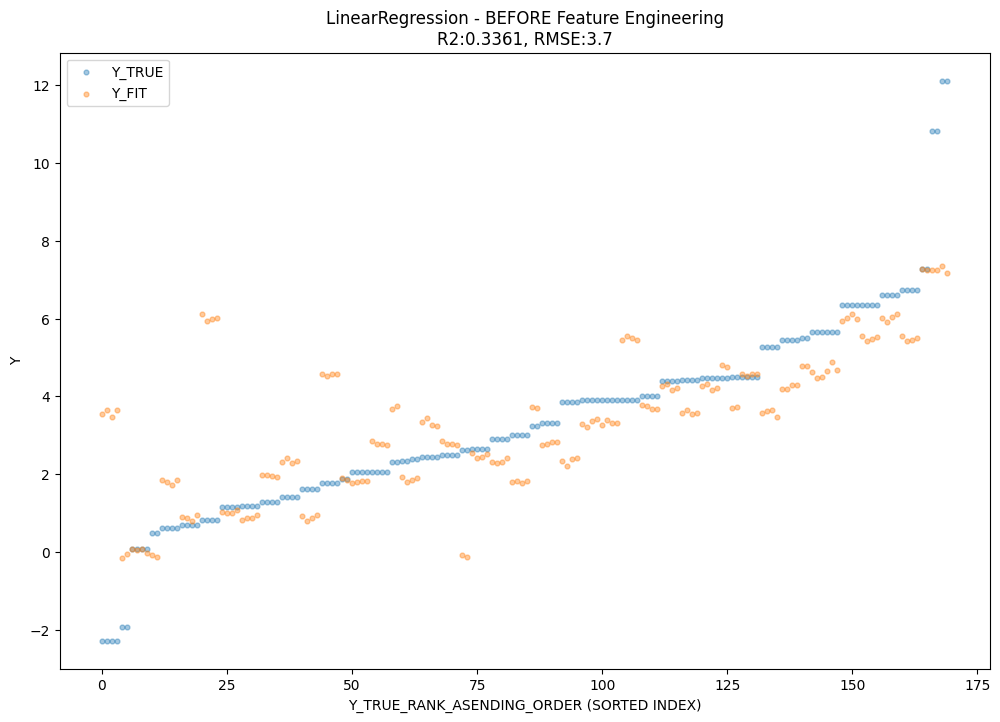

In [5]:
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model_lr.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model_lr.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('LinearRegression - BEFORE Feature Engineering' + '\n' + 'R2:' + str(round(r2_linreg_before, 4)) + ', RMSE:' + str(round(rmse_linreg_before, 2)))
plt.legend()

In [6]:

# assuming df is your DataFrame
df = lista_train.drop(['energia'], axis=1)

# replace zeros with np.nan
df = df.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df = enc.fit_transform(df)

# create H matrix
H = np.zeros(df.shape)

# specify the position of non-zero values in H
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if not np.isnan(df.iloc[i, j]):
            H[i, j] = j+1  # or just 1, based on your requirements



In [7]:

X_train_array = np.concatenate((onehot_df, H), axis=1)
X_train_encoded = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

input_shape_train = (X_train_encoded.shape[1],1)
# assuming onehot_df_encoded and H are your input data and are numpy arrays
# reshape data for Conv1D, the format should be (n_samples, steps, channels)
onehot_df_encoded = onehot_df.reshape((170, 24, 1))
H_encoded = H.reshape((170, 4, 1))

# target data
y_train = np.array(y_train)
input_shape_train

(28, 1)

In [8]:
# assuming df is your DataFrame
df_test = lista_test.drop(['energia'], axis=1)

# replace zeros with np.nan
df_test = df_test.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df_test = enc.fit_transform(df_test)

# create H matrix
H_test = np.zeros(df_test.shape)

# specify the position of non-zero values in H
for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if not np.isnan(df_test.iloc[i, j]):
            H_test[i, j] = j+1  # or just 1, based on your requirements


In [9]:
onehot_df_test_encoded = onehot_df_test.reshape((onehot_df_test.shape[0], 24, 1))
H_test_encoded = H_test.reshape((H_test.shape[0], 4, 1))

X_test_array = np.concatenate((onehot_df_test, H_test), axis=1)
X_test_encoded = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))
input_shape_test = (X_test_encoded.shape[1],1)
# target data
y_test = np.array(y_test)
y_test.shape

(1120,)

In [10]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Input,  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Flatten, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.linear_model import Ridge

class RidgeLayer(Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(RidgeLayer, self).__init__(**kwargs)
        self.alpha = alpha

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], 1),
                                      initializer='glorot_uniform',
                                      trainable=False)

    def call(self, inputs):
        return K.dot(inputs, self.kernel) + self.alpha

def build_model(hp):
    # Input layers
    input_onehot_1d = Input(shape=(28, 1))

    # Flatten layers
    flat_onehot_1d = Flatten()(input_onehot_1d)

    # Ridge model
    solver = hp.Choice('solver', values=['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    alpha = hp.Float('alpha', min_value=0.01, max_value=1.0)
    ridge_output = RidgeLayer(alpha=alpha)(flat_onehot_1d)

    # Scaler layer
    scaler_output = BatchNormalization()(ridge_output)

    # Output layer
    output_1d = Dense(1, activation='linear')(scaler_output)
    output_1d = output_1d * 5

    # Create model
    model_1d = Model(inputs=[input_onehot_1d], outputs=output_1d)

    # Compile model
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model_1d.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

    return model_1d





train_data = np.concatenate((onehot_df_encoded, H_encoded), axis = 1)
# assuming onehot_df_train, H_train, y_train are your training datasets
input_shape_onehot = (train_data.shape[1], 1)

train_data, y_train = shuffle(train_data, y_train)



tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=25,
    executions_per_trial=15,
    directory='output',
    project_name='resmol_ridge',
    overwrite=True)

tuner.search_space_summary()

# Start the search for the best hyperparameters
tuner.search(train_data, y_train,
             epochs=80,
             validation_split=0.2)

# After the tuner is finished, retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# And its hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]






Trial 25 Complete [00h 01m 13s]
val_loss: 5.646320438385009

Best val_loss So Far: 5.53797664642334
Total elapsed time: 00h 30m 11s
INFO:tensorflow:Oracle triggered exit


In [11]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_data, y_train, epochs=150, validation_split=0.2, verbose=1)

# Let's assume you have a test set


Epoch 1/150
5/5 [==============================] - 1s 37ms/step - loss: 69.6249 - mae: 6.8859 - val_loss: 31.4858 - val_mae: 4.5080
Epoch 2/150
5/5 [==============================] - 0s 10ms/step - loss: 58.4292 - mae: 6.4818 - val_loss: 28.4426 - val_mae: 4.2877
Epoch 3/150
5/5 [==============================] - 0s 14ms/step - loss: 48.3213 - mae: 5.9056 - val_loss: 25.6888 - val_mae: 4.0946
Epoch 4/150
5/5 [==============================] - 0s 10ms/step - loss: 40.5337 - mae: 5.3357 - val_loss: 23.4048 - val_mae: 3.9307
Epoch 5/150
5/5 [==============================] - 0s 8ms/step - loss: 34.1284 - mae: 4.8170 - val_loss: 21.1759 - val_mae: 3.7550
Epoch 6/150
5/5 [==============================] - 0s 9ms/step - loss: 28.4789 - mae: 4.3752 - val_loss: 19.3171 - val_mae: 3.5970
Epoch 7/150
5/5 [==============================] - 0s 9ms/step - loss: 25.2475 - mae: 4.1004 - val_loss: 17.7410 - val_mae: 3.4548
Epoch 8/150
5/5 [==============================] - 0s 8ms/step - loss: 21.8215 

In [12]:
#onehot_df_test_encoded, H_test_encoded = prepare_test_data(onehot_df_test, H_test)  # You need to ensure that your test data is prepared in the same way as your training data
test_data = np.concatenate((onehot_df_test_encoded, H_test_encoded), axis = 1)
# Now you can make predictions on your test set
predictions = model.predict(test_data)




35/35 [==============================] - 0s 647us/step


In [13]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('Mean Absolute Error (MAE): ', mae)
print('R-squared Score (R^2): ', r2)

Mean Squared Error (MSE):  29.094435058370028
Root Mean Squared Error (RMSE):  5.393925755733947
Mean Absolute Error (MAE):  3.542210978790986
R-squared Score (R^2):  -0.41063387580226296


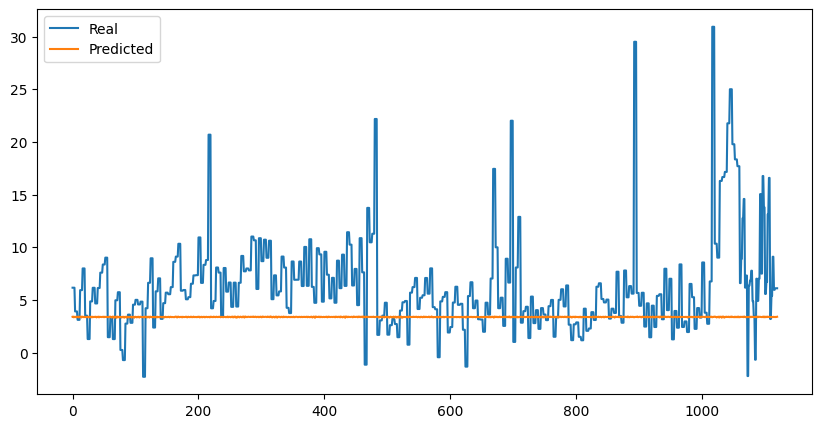

In [14]:
import matplotlib.pyplot as plt

# plot predicted vs real values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

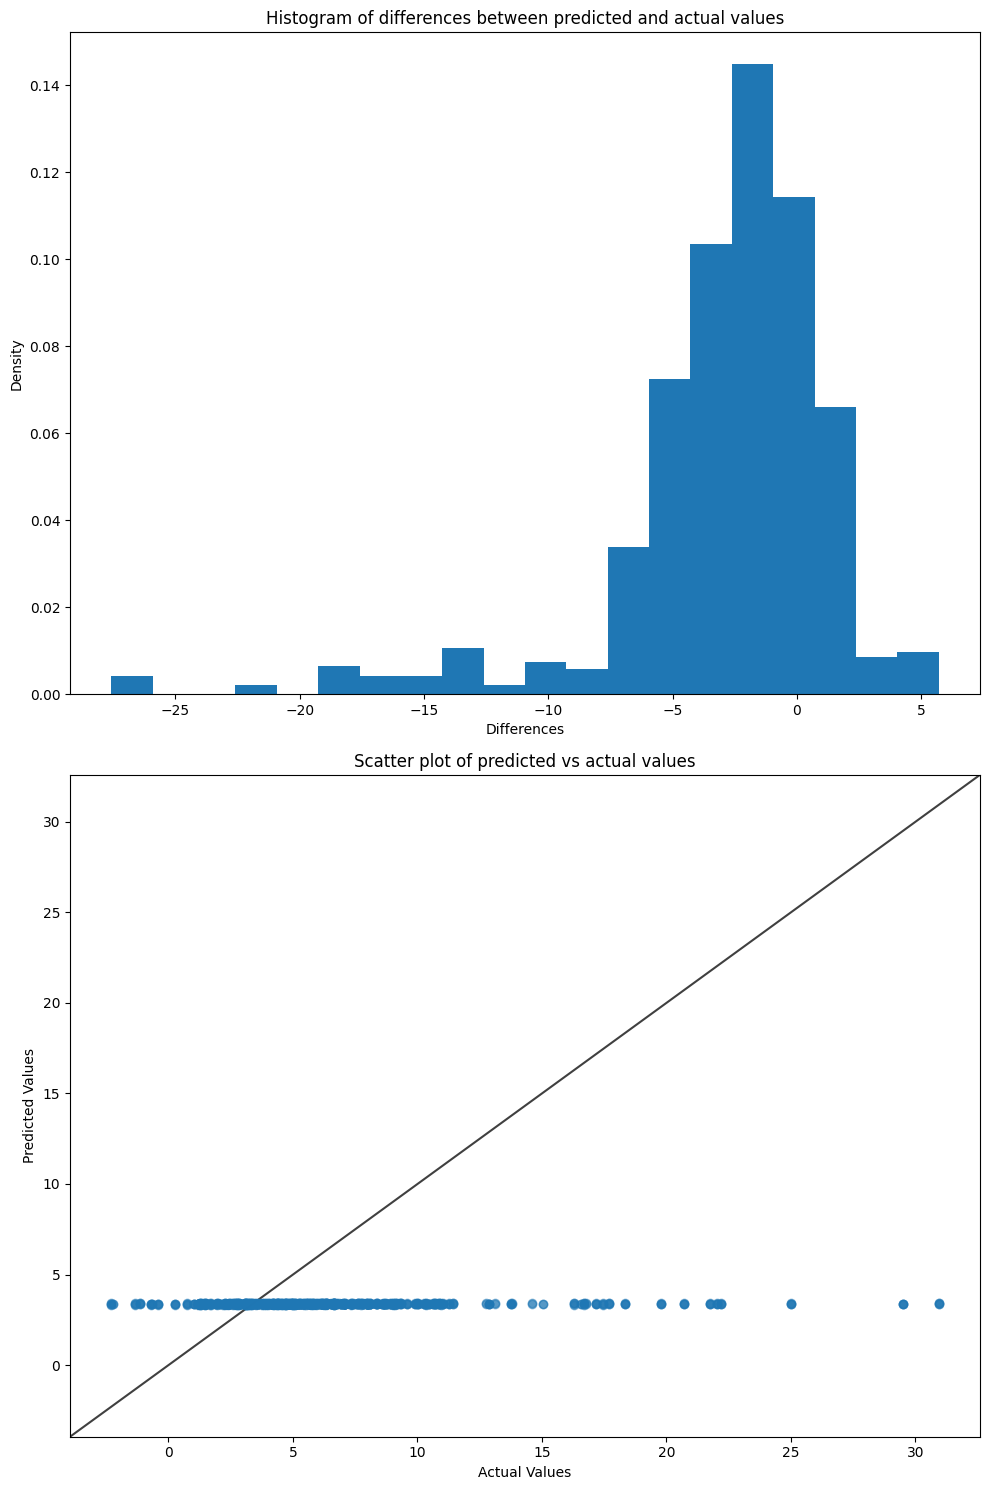

In [15]:

differences = predictions.flatten() - y_test.flatten() # This will give the difference between your predictions and the actual values

#Create a figure with two subplots: a histogram of the differences and a scatter plot of predicted vs real values
fig, axs = plt.subplots(nrows=2, figsize=(10, 15))

#Plot histogram
axs[0].hist(differences, bins=20, density=True)
axs[0].set_title('Histogram of differences between predicted and actual values')
axs[0].set_xlabel('Differences')
axs[0].set_ylabel('Density')

#Plot scatter
axs[1].scatter(y_test, predictions, alpha=0.5)
axs[1].set_title('Scatter plot of predicted vs actual values')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')

#Draw a diagonal line on the scatterplot
lims = [np.min([axs[1].get_xlim(), axs[1].get_ylim()]), # min of both axes
np.max([axs[1].get_xlim(), axs[1].get_ylim()])] # max of both axes
axs[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
axs[1].set_xlim(lims)
axs[1].set_ylim(lims)

plt.tight_layout()
plt.show()